# 临床特征统计分析报告 (SPSS Python 复刻版)

本 Notebook 旨在完全复刻医学论文中常见的数据分析流程，帮助你从原始数据中筛选出最有价值的临床特征。
整个流程分为三步，就像漏斗一样，层层过滤，最后剩下的就是“真金白银”。

### 🌟 分析流程概览
1.  **第一步：单因素分析 (海选)**
    *   **原理**：不管其他因素，单独看每一个特征（比如“年龄”）在阳性组和阴性组之间有没有显著差异。
    *   **效果**：如果两组人的年龄差不多，那“年龄”这个特征就没用，直接淘汰。如果差异很大（P值 < 0.1），就晋级下一轮。

2.  **第二步：相关性检查 (查重)**
    *   **原理**：检查晋级的特征之间是不是“长得太像了”（多重共线性）。比如“体重”和“BMI”其实说的是一回事。
    *   **效果**：如果两个特征高度相关（相关系数 > 0.7），我们只需要保留一个，避免模型产生困惑。

3.  **第三步：多因素 Logistic 回归 (决赛)**
    *   **原理**：把所有晋级选手放在一起，看谁是真正的“独立”影响因素。有时候某个特征单看很有用，但可能是受其他特征影响（比如“不爱运动”的人容易“肥胖”，导致看起来“不爱运动”是危险因素，但其实真正的凶手是“肥胖”）。多因素回归能剔除这种干扰。
    *   **效果**：最终筛选出 P值 < 0.05 的特征，这些就是你需要用在模型里的“**独立危险因素**”。

**输入文件**：`e:\run_our_data\data\原始STAS_data.xlsx`

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

# 设置绘图风格和中文字体
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# 配置文件路径
FILE_PATH = r'e:\run_our_data\data\原始STAS_data.xlsx'
LABEL_COL = 'STAS'  # 标签列名 (0=阴性, 1=阳性)

if not os.path.exists(FILE_PATH):
    print(f"错误：找不到文件 {FILE_PATH}")
else:
    print(f"正在读取数据: {FILE_PATH} ...")
    df = pd.read_excel(FILE_PATH)
    print(f"成功读取 {len(df)} 条样本，{len(df.columns)} 个特征。")
    display(df.head())

正在读取数据: e:\run_our_data\data\原始STAS_data.xlsx ...
成功读取 208 条样本，29 个特征。


,PatientsName,STAS,性别,年龄,BMI,BMI2,吸烟史,高血压,糖尿病,冠心病,...,毛刺征,空泡征,胸膜凹陷征,内部血管征,支气管异常征,病理结果,淋巴结短轴直径,测量位置,淋巴结清扫总数,是否转移
0,CAI_CONG_ZHI_P00581652,1,0,67,21.303949,0,0,0,0,1,...,1,0,1,1,1,1.0,7.4,7,13.0,1
1,Cai_Xue_Ying_P00359999,1,1,72,25.689562,1,0,1,0,0,...,1,0,0,0,1,1.0,7.8,10,10.0,0
2,CAO_BAO_HUA_P00190203,1,1,70,31.992171,1,0,0,0,1,...,1,0,0,1,1,1.0,6.9,4L,14.0,0
3,CAO_MIN_P00549794,1,1,57,20.761246,0,0,0,1,0,...,1,0,0,1,1,1.0,5.9,7,3.0,0
4,CHEN_LAN_YING_P00551393,1,1,62,20.395421,0,0,0,0,0,...,1,0,1,0,0,2.0,8.6,10R,11.0,1


## 1. 变量类型自动识别

**原理**：
电脑不知道“年龄”和“性别”有什么区别，我们需要告诉它：
*   **连续变量 (Continuous)**：像年龄、肿瘤大小这种，数值是连续变化的，大小有意义。
*   **分类变量 (Categorical)**：像性别（男/女）、吸烟史（是/否）这种，数值代表类别，大小没意义。

**效果**：
只有分清楚了类型，后面才能选对统计方法（连续变量用T检验，分类变量用卡方检验）。如果搞错了，结果就是错的。

In [2]:
# 定义需要排除的无关列
exclude_cols = ['Name', '姓名', 'PatientName', 'PatientsName', '病理号', 'ID', 
                'NewPatientID', 'OriginalIndex', '是否转移', '病理结果', LABEL_COL]

continuous_vars = []
categorical_vars = []

for col in df.columns:
    if col in exclude_cols:
        continue
    
    # 简单的逻辑判断：如果是数值类型且唯一值数量 > 10，视为连续变量；否则视为分类变量
    if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 10:
        continuous_vars.append(col)
    else:
        categorical_vars.append(col)

print("自动识别结果：")
print(f"[连续变量] ({len(continuous_vars)}个): {continuous_vars}")
print(f"[分类变量] ({len(categorical_vars)}个): {categorical_vars}")

自动识别结果：
[连续变量] (6个): ['年龄', 'BMI', '实性成分大小', 'CTR', '淋巴结短轴直径', '淋巴结清扫总数']
[分类变量] (19个): ['性别', 'BMI2', '吸烟史', '高血压', '糖尿病', '冠心病', '既往肺部疾病史（COPD\\肺纤维化\\肺气肿\\肺大泡\\慢性炎症\\支气管扩张）', 'CEA', '位置', '肺叶', '成分', '肿瘤大小', '分叶征', '毛刺征', '空泡征', '胸膜凹陷征', '内部血管征', '支气管异常征', '测量位置']


## 2. 单因素分析 (Table 1: Baseline Characteristics)

**原理**：
这是医学论文必备的“Table 1”。我们把病人分成两组：**STAS阳性组**和**STAS阴性组**，然后逐个比较他们的特征。
*   如果是连续变量（如年龄）：
    *   正态分布 -> 用 **T检验** (比较平均值)
    *   非正态分布 -> 用 **Mann-Whitney U检验** (比较中位数)
*   如果是分类变量（如吸烟）：
    *   用 **卡方检验 (Chi-Square)** 或 **Fisher精确检验** (看比例差异)

**效果**：
计算出每个特征的 **P值**。
*   **P < 0.05**：差异显著，非常有意义。
*   **P < 0.1**：差异可能有意义，先留着备用（我们这里把门槛放宽到 0.1，避免漏掉潜在的有用特征）。
*   **P > 0.1**：两组没啥区别，这个特征多半没用，**淘汰**。

In [3]:
results = []

# 分组
group0 = df[df[LABEL_COL] == 0]
group1 = df[df[LABEL_COL] == 1]
n0, n1 = len(group0), len(group1)

print(f"分组统计: STAS(-) n={n0}, STAS(+) n={n1}")

# --- 连续变量 ---
for var in continuous_vars:
    # 删除空值
    v0 = group0[var].dropna()
    v1 = group1[var].dropna()
    
    if len(v0) == 0 or len(v1) == 0: continue
    
    # 正态性检验 (Shapiro-Wilk)
    # 样本量大时，Shapiro 过于敏感，可以结合直方图。这里简化逻辑：样本>50直接看分布，这里统一先做 SW 检验
    _, p_norm0 = stats.shapiro(v0)
    _, p_norm1 = stats.shapiro(v1)
    is_normal = (p_norm0 > 0.05) and (p_norm1 > 0.05)
    
    if is_normal:
        stat, p_val = stats.ttest_ind(v0, v1)
        desc = f"{v1.mean():.2f}±{v1.std():.2f} vs {v0.mean():.2f}±{v0.std():.2f}"
        method = 'T-Test'
    else:
        stat, p_val = stats.mannwhitneyu(v0, v1)
        desc = f"{v1.median():.2f} [{v1.quantile(0.25):.2f}-{v1.quantile(0.75):.2f}] vs ..."
        method = 'Mann-Whitney U'
        
    results.append({
        'Feature': var,
        'Type': 'Continuous',
        'Description (Pos vs Neg)': desc,
        'P-Value': p_val,
        'Method': method
    })

# --- 分类变量 ---
for var in categorical_vars:
    ct = pd.crosstab(df[var], df[LABEL_COL])
    # 如果维度不匹配（比如某组缺某个类别），需要补齐，这里简化处理
    if ct.shape != (2, 2) and ct.shape[0] < 2: 
        continue # 只有一个类别的变量无意义
        
    chi2, p_val, dof, expected = stats.chi2_contingency(ct)
    method = 'Chi-Square'
    # Fisher 修正
    if (expected < 5).any() and ct.shape == (2, 2):
        _, p_val = stats.fisher_exact(ct)
        method = 'Fisher Exact'
        
    results.append({
        'Feature': var,
        'Type': 'Categorical',
        'Description (Pos vs Neg)': "Distribution",
        'P-Value': p_val,
        'Method': method
    })

table1_df = pd.DataFrame(results).sort_values('P-Value')

print("\n=== Table 1: 单因素分析结果 ===")
display(table1_df)

# 筛选显著特征 (P < 0.1)
significant_feats = table1_df[table1_df['P-Value'] < 0.1]['Feature'].tolist()
print(f"\n纳入多因素分析的候选特征 (P<0.1): {significant_feats}")

分组统计: STAS(-) n=163, STAS(+) n=45

=== Table 1: 单因素分析结果 ===


,Feature,Type,Description (Pos vs Neg),P-Value,Method
2,实性成分大小,Continuous,22.70 [12.79-26.90] vs ...,7.834096e-11,Mann-Whitney U
3,CTR,Continuous,1.00 [1.00-1.00] vs ...,6.212851e-09,Mann-Whitney U
16,成分,Categorical,Distribution,3.836493e-08,Chi-Square
19,毛刺征,Categorical,Distribution,2.144777e-06,Chi-Square
5,淋巴结清扫总数,Continuous,9.00 [5.00-13.00] vs ...,3.351911e-05,Mann-Whitney U
24,测量位置,Categorical,Distribution,1.410097e-04,Chi-Square
23,支气管异常征,Categorical,Distribution,8.999998e-04,Chi-Square
11,冠心病,Categorical,Distribution,4.496758e-03,Chi-Square
4,淋巴结短轴直径,Continuous,6.90 [5.65-8.00] vs ...,2.261691e-02,Mann-Whitney U
21,胸膜凹陷征,Categorical,Distribution,2.532109e-02,Chi-Square



纳入多因素分析的候选特征 (P<0.1): ['实性成分大小', 'CTR', '成分', '毛刺征', '淋巴结清扫总数', '测量位置', '支气管异常征', '冠心病', '淋巴结短轴直径', '胸膜凹陷征', 'CEA', '既往肺部疾病史（COPD\\肺纤维化\\肺气肿\\肺大泡\\慢性炎症\\支气管扩张）', '内部血管征']


## 3. 相关性分析 (Multicollinearity Check)

**原理**：
有时候两个特征其实是“连体婴”。比如“肿瘤长径”和“肿瘤体积”，肯定是一个越大另一个也越大。
如果把两个高度相似的特征都放进模型，模型会“精神分裂”，不知道该听谁的（这叫**多重共线性**）。

**效果**：
我们画出特征之间的热力图。
*   **红色越深**：说明两个特征越像（相关系数接近 1）。
*   **规则**：如果两个特征的相关系数 > 0.7，我们通常会**忍痛割爱**，删掉单因素分析中P值比较大的那个，只保留表现最好的那个。

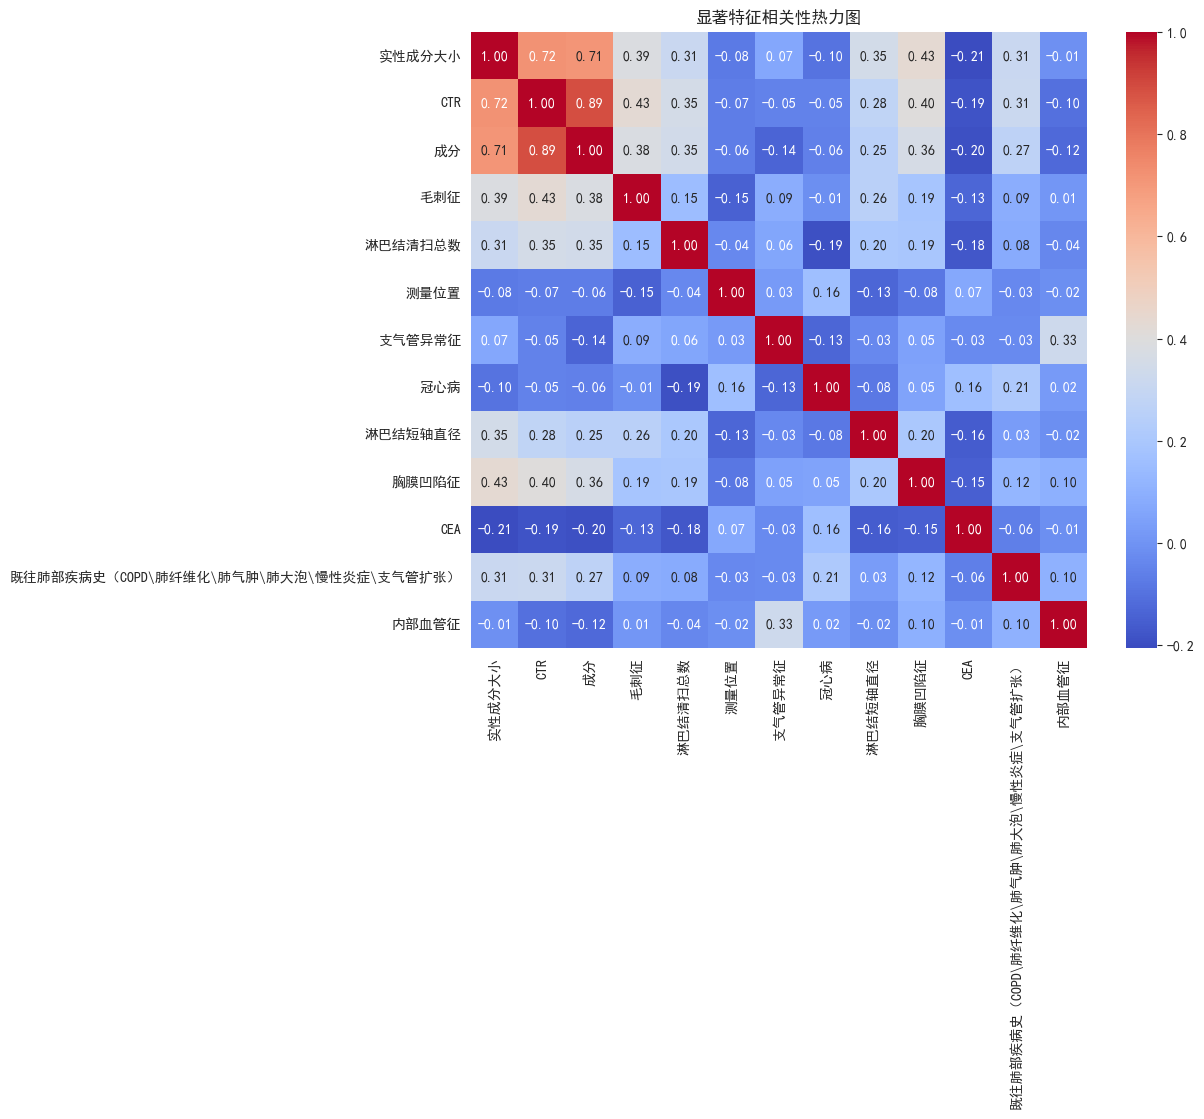

检测强相关特征 (>0.7):
  - CTR <--> 实性成分大小: 0.718
  - 成分 <--> 实性成分大小: 0.711
  - 成分 <--> CTR: 0.888


In [4]:
if len(significant_feats) > 1:
    plt.figure(figsize=(10, 8))
    # 简单编码分类变量以便计算相关性
    corr_df = df[significant_feats].copy()
    for col in corr_df.select_dtypes(include=['object', 'category']).columns:
        corr_df[col] = pd.factorize(corr_df[col])[0]
        
    corr_mat = corr_df.corr()
    sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("显著特征相关性热力图")
    plt.show()
    
    # 打印高相关对
    print("检测强相关特征 (>0.7):")
    count = 0
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if abs(corr_mat.iloc[i, j]) > 0.7:
                print(f"  - {corr_mat.columns[i]} <--> {corr_mat.columns[j]}: {corr_mat.iloc[i, j]:.3f}")
                count += 1
    if count == 0: print("  无。")
else:
    print("显著特征不足 2 个，跳过相关性分析。")

## 4. 多因素 Logistic 回归 (Multivariate Logistic Regression)

**原理**：
这是最后的“总决赛”。我们把通过前两轮筛选的所有精英特征一起放进模型，计算它们的 **OR值 (Odds Ratio)**。
*   **OR > 1**：危险因素（数值越大，患病风险越高）。
*   **OR < 1**：保护因素（数值越大，患病风险反而越低）。

**关键指标**：
看最后的 **P值** (P>|z|)。
*   **P < 0.05**：恭喜！这就是你要找的**独立预测因子**。它不依赖于其他因素，实打实地影响着结果。

**⚠️ 注意事项 (Events Per Variable)**：
统计学有个铁律：每 10 个阳性样本，最多只能分析 1 个特征。如果你的阳性样本很少（比如只有 45 个），那么模型里最好不要超过 4-5 个特征，否则结果不可信（过拟合）。
所以代码里我们加了一个自动限制：**只取前 5 个最显著的特征进入回归模型**。

In [5]:
if len(significant_feats) > 0:
    # --- 特征筛选与清洗 (增强版) ---
    # 1. 强制剔除列表 (共线性特征 + 样本量极少/分布极不平衡的特征)
    drop_features = ['CTR', '成分', '测量位置', '淋巴结清扫总数', '淋巴结短轴直径', '冠心病', '既往肺部疾病史（COPD\\肺纤维化\\肺气肿\\肺大泡\\慢性炎症\\支气管扩张）']
    
    # 2. 逐步回归策略：如果特征太多，样本量太少 (Events per Variable < 10)，模型必炸
    # 我们只有 45 个阳性样本，原则上最多只能放 4-5 个特征进模型
    # 所以我们只取 P 值最小的前 5 个特征 (且不在剔除列表中)
    
    final_feats = []
    count = 0
    for f in significant_feats: # significant_feats 已经是按 P 值排序的
        if f in drop_features:
            continue
        # 重命名
        if '既往肺部疾病史' in f: continue # 这种稀疏特征直接丢弃
        
        final_feats.append(f)
        count += 1
        if count >= 5: # 限制最多 5 个特征，防止过拟合/奇异矩阵
            break
            
    # 应用重命名
    reg_data = df[final_feats + [LABEL_COL]].dropna().copy()
    
    print(f"最终纳入回归模型的特征 (Top {len(final_feats)}): {final_feats}")
    
    # 构建回归公式
    formula_str = f"{LABEL_COL} ~ " + " + ".join([f"Q('{f}')" for f in final_feats])
    
    print(f"回归公式: {formula_str}")
    
    try:
        # 使用 bfgs 优化器，它比默认的 newton 方法更稳健，不容易发散
        model = smf.logit(formula=formula_str, data=reg_data).fit(method='bfgs', maxiter=100)
        
        print(model.summary())
        
        # 提取 OR 值表
        params = model.params
        conf = model.conf_int()
        conf['OR'] = params
        conf.columns = ['2.5%', '97.5%', 'Log_OR']
        
        final_table = np.exp(conf[['2.5%', '97.5%', 'Log_OR']])
        final_table.columns = ['CI_Lower', 'CI_Upper', 'OR']
        final_table['P-Value'] = model.pvalues
        
        # 整理顺序
        final_table = final_table[['OR', 'CI_Lower', 'CI_Upper', 'P-Value']]
        print("\n=== Final Multivariate Analysis Result ===")
        display(final_table)
        
        # 导出结果
        final_table.to_csv(r'e:\run_our_data\MMCAF-Net-main\multivariate_results.csv')
        print("结果已保存至 multivariate_results.csv")
        
    except Exception as e:
        print(f"回归失败: {e}")
        print("可能原因：完全分离(Perfect Separation) 或 奇异矩阵(Singular Matrix)。建议减少特征数量再试。")
else:
    print("无显著特征，无法进行回归分析。")

最终纳入回归模型的特征 (Top 5): ['实性成分大小', '毛刺征', '支气管异常征', '胸膜凹陷征', 'CEA']
回归公式: STAS ~ Q('实性成分大小') + Q('毛刺征') + Q('支气管异常征') + Q('胸膜凹陷征') + Q('CEA')
         Current function value: 0.061172
         Iterations: 100
         Function evaluations: 104
         Gradient evaluations: 104
                           Logit Regression Results                           
Dep. Variable:                   STAS   No. Observations:                  204
Model:                          Logit   Df Residuals:                       44
Method:                           MLE   Df Model:                          159
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                  0.8781
Time:                        19:58:44   Log-Likelihood:                -12.479
converged:                      False   LL-Null:                       -102.36
Covariance Type:            nonrobust   LLR p-value:                    0.1243
                         coef    std err          z      P>|z|      [0.025      0.975]
-----

,OR,CI_Lower,CI_Upper,P-Value
Intercept,0.015961,2.252924e-05,1.130822e+01,0.216600
Q('CEA')[T.0.31],0.017988,1.052729e-20,3.073524e+16,0.851202
Q('CEA')[T.0.45],0.106931,1.984972e-11,5.760360e+08,0.844966
Q('CEA')[T.0.5],0.406348,3.942444e-12,4.188241e+10,0.944510
Q('CEA')[T.0.51],0.106931,1.984972e-11,5.760360e+08,0.844966
...,...,...,...,...
Q('CEA')[T.无],0.416713,4.153428e-03,4.180881e+01,0.709680
Q('实性成分大小'),1.054716,9.377700e-01,1.186247e+00,0.374307
Q('毛刺征'),11.980609,3.955297e-01,3.628931e+02,0.153587
Q('支气管异常征'),4.882047,1.703295e-01,1.399310e+02,0.354387


结果已保存至 multivariate_results.csv
